'''
we could use a  technique that could segment all the possible cells in the prediction of distance transform.  
when small cells are  recognized, other small pieces and noise would also be identified.
This will lead to over-segmentation.
Here we utilize the over-segmentation to segment the mitosis and apoptosis cells. 
Then, we extract the small cells that below size threshold. And use an identification CNN  to identify them,
only the apoptosis and mitosis cells are kept. 
After correctly segment these cells, we remove these cells from the prediction of distance transform. 
'''

In [7]:
import numpy as np
from skimage.segmentation import watershed,clear_border
from skimage.io import imread
from matplotlib import pyplot as plt
import scipy.ndimage as ndi
import pickle
import os
from os import listdir
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects,local_maxima,h_maxima,disk,dilation
from skimage.measure import regionprops,label
from skimage.color import label2rgb
from PIL import Image, ImageDraw, ImageFont
from resnet50 import res_model
from math import pi
import cv2
import glob
from skimage.exposure import equalize_adapthist
from pilutil import toimage
from cnn_prep_data import keep_aspect_resize,obj_transform
import pandas as pd
from scipy import ndimage

In [3]:
main_path='/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/'
input_path=main_path+'img/'
output_path=main_path+'output/'
crop_path=main_path+'crop/'
fragment_path=crop_path+'fragment/'

experi_setting='190322'
posi_end=1

In [8]:
low_h=0.05
high_h=0.8
small_obj_thres=1500
mask_thres=0.02

fragment_size_thres=3600


In [5]:
def color_num(labels):
    
    """draw color numbers on the center of the label"""
    label_rgb=label2rgb(labels,bg_label=0) # Return an RGB image where color-coded labels are painted over the image.
    img_rgb= toimage(label_rgb)
    base = img_rgb.convert('RGBA')
    # make a blank image for the text, initialized to transparent text color
    txt = Image.new('RGBA', base.size, (255,255,255,0))
    # get a font
    fnt = ImageFont.truetype('arial.ttf', 40)
    # get a drawing context
    d = ImageDraw.Draw(txt)
    for region in regionprops(labels):
        cx=int(region.centroid[1])     
        cy=int(region.centroid[0])
        d.text((cx,cy),str(labels[cy][cx]),font=fnt,fill=(255,255,255,255)) 
    out = Image.alpha_composite(base, txt)       
    return out

In [6]:
#this is faster than the one from lineage mapper,only with matrix calculation
def compute_overlap_matrix(seg1,seg2):
    """Calc neighboring img labels overlap region, as a matrix."""
    nb_cell_1=np.amax(seg1)
    nb_cell_2=np.amax(seg2)

    seg_overlap=np.zeros((nb_cell_1,nb_cell_2))
    for obj_idx1 in range(nb_cell_1):
        obj_num1=obj_idx1+1
        sc_img=(seg1==obj_num1)
        ol_judge=np.logical_and(sc_img,seg2)
        ol_value=np.multiply(ol_judge,seg2)
        ol_obj2=np.unique(ol_value).tolist()
        #ol_obj2=ol_obj2[ol_obj2!=0]
        ol_obj2.remove(0)
        if len(ol_obj2)>0:
            for obj_num2 in ol_obj2:
                ol_area=np.sum(ol_value==obj_num2)
                obj_idx2=obj_num2-1
                seg_overlap[obj_idx1][obj_idx2]=ol_area  

    return seg_overlap

In [7]:
#-------calculate the cell fusion -----------------------
def cal_cell_fusion(frame_overlap):
    nb_cell_1=frame_overlap.shape[0]
    nb_cell_2=frame_overlap.shape[1]
    
    prefuse_group=[]#each element is a list include all prefuse cells in a fuse event, corresponding to postfuse_cells
    postfuse_cells=[]#include: img_num,obj_num
    frame_fusion = np.zeros(frame_overlap.shape)
    for source_o_n in range(1,nb_cell_1+1):
        #find target whose max_overlap mother is source
        ol_target=frame_overlap[source_o_n-1,:]
        if np.all(ol_target==0):#if source obj have no overlap target
            target_o_n=0    
        else:      
            target_o_n=np.argmax(frame_overlap,axis=1)[source_o_n-1]+1#axis=1,maximum of each row,return column index
        
       
        if target_o_n> 0:
            frame_fusion[source_o_n-1, target_o_n-1] = 1
    
        #Compute the sum vector S which is the sum of all the columns of frame_fusion matrix. The fusion target region
        #will have at least 2 cells tracked to it => S>1
    S = np.sum(frame_fusion, axis=0)
    frame_fusion[:, S==1] = 0          
    # Update the sum vector
    S = np.sum(frame_fusion, axis=0)

    for i in range(len(np.where(S >= 2)[0])):
        f_group=[]
        postfuse_cells.append([np.where(S >= 2)[0][i]+1])#num of prefuse cells:S[np.where(S >= 2)[0][i]]
        frame_fusion_i=frame_fusion[:,np.where(S >= 2)[0][i]]

        for r in range(len(np.where(frame_fusion_i==1)[0])):
            #fuse_pairs.append([img_num_1,np.where(frame_fusion_i==1)[0][r]+1,img_num_2,np.where(S >= 2)[0][i]+1])
            f_group.append(np.where(frame_fusion_i==1)[0][r]+1)
        prefuse_group.append(f_group)
    return postfuse_cells,prefuse_group

In [8]:
#---do not remove small objects before calculate overlap
def hmax_watershed(img,h_thres,small_obj_thres,mask_thres=0):


   
    local_hmax=h_maxima(img,h_thres)
    local_hmax_label=label(local_hmax,connectivity=1)


    labels = watershed(-img, local_hmax_label, mask=img>mask_thres)
#     labels = remove_small_objects(labels, small_obj_thres)    
#     labels=label(labels,connectivity =2)
    print(np.amax(labels))
    return labels,local_hmax_label

In [9]:
def generate_single_cell_img(img,seg,img_num,obj_num):
    
    #single_obj_img=morphology.binary_dilation(seg_img==obj_num,morphology.diamond(16))
    single_obj_img=seg==obj_num
    single_obj_img=label(single_obj_img)
    rps=regionprops(single_obj_img)
    candi_r=[r for r in rps if r.label==1][0]
    candi_box=candi_r.bbox        
    single_cell_img=single_obj_img*img
    crop_img=single_cell_img[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]

    return crop_img

In [12]:
fc_setting=experi_setting+'_fc'
fp_setting=experi_setting+'_fp'
img_ind=500
for posi in range(1,posi_end+1):
    img_path=input_path+str(posi)+'/'
    img_list=sorted(listdir(img_path))
    
    dir_path=output_path+str(posi)+'/'
    
    
    reg_path=dir_path+'reg/'
    reg_list=sorted(listdir(reg_path))

        
#     for i in range(len(img_list)):
    for i in range(img_ind,img_ind+1):
        img_num=i+1
    
        img=imread(img_path+img_list[i])

        reg=imread(reg_path+reg_list[i])

        img_name=img_list[i][0:len(img_list[i])-4]

        
        low_h_seg,low_h_markers=hmax_watershed(reg,h_thres=low_h,small_obj_thres=small_obj_thres,mask_thres=mask_thres)
        
        rgb_num1=color_num(low_h_seg)
#         plt.figure(figsize=[12,12])
#         plt.imshow(rgb_num1)
#         plt.show()
        
        
        high_h_seg,high_h_markers=hmax_watershed(reg,h_thres=high_h,small_obj_thres=small_obj_thres,mask_thres=mask_thres)
        
        rgb_num2=color_num(high_h_seg)
#         plt.figure(figsize=[12,12])
#         plt.imshow(rgb_num2)
#         plt.show()
        
        seg_overlap=compute_overlap_matrix(low_h_seg,high_h_seg)
        fuse_cells,fuse_group=cal_cell_fusion(seg_overlap)

        
        for m in range(len(fuse_cells)):
            print(fuse_cells[m])
            print(fuse_group[m])
            
            
            fc_obj=generate_single_cell_img(img,high_h_seg,img_num,fuse_cells[m][0])

            
            fc_img=toimage(fc_obj,high=np.max(fc_obj),low=np.min(fc_obj),mode='I')
            fc_img.save(crop_path+'/'+fc_setting+'_i'+str(img_num)+'_o'+str(fuse_cells[m][0])+'.png')
            

            for n in range(len(fuse_group[m])):
                fp_obj=generate_single_cell_img(img,low_h_seg,img_num,fuse_group[m][n])
                
                fp_img=toimage(fp_obj,high=np.max(fp_obj),low=np.min(fp_obj),mode='I')
                fp_mask=fp_obj>0
                if np.sum(fp_mask)<fragment_size_thres:
                    fp_img.save(fragment_path+'/'+fp_setting+'_i'+str(img_num)+'_o'+str(fuse_group[m][n])+'.png')
                else:
                    fp_img.save(crop_path+'/'+fp_setting+'_i'+str(img_num)+'_o'+str(fuse_group[m][n])+'.png')



6


/home/zoro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  app.launch_new_instance()


6


/home/zoro/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


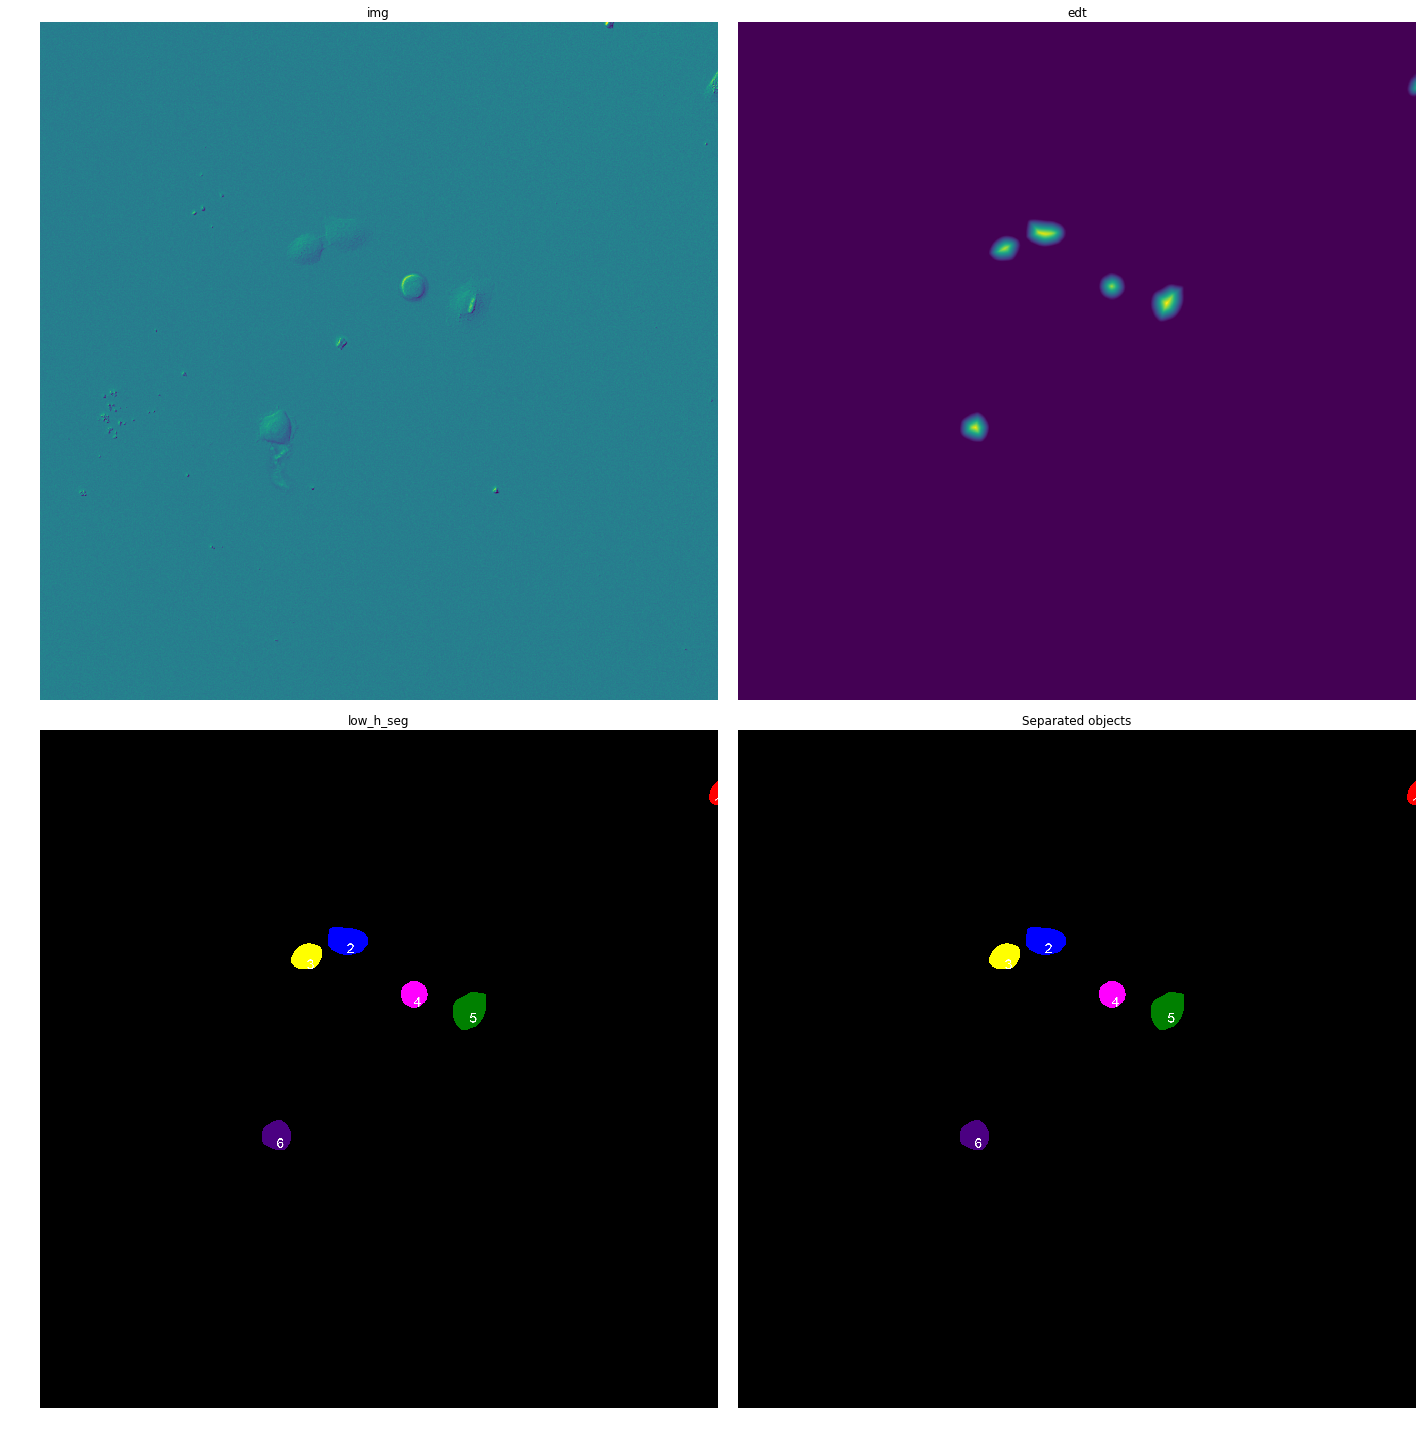

In [13]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20, 20), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
ax[0].imshow(img)
ax[0].set_title('img')
ax[1].imshow(reg)
ax[1].set_title('edt')

ax[2].imshow(rgb_num1, cmap=plt.cm.Spectral, interpolation='nearest')
ax[2].set_title('low_h_seg')

# ax[2].imshow(reg_img, cmap=plt.cm.gray)
# ax[2].autoscale(False)
# ax[2].plot(local_hmy[:], local_hmx[:], 'r.')#reverse order of cx and cy, because they are from skimage
# ax[2].axis('off')
# ax[2].set_title('Peak local max')

ax[3].imshow(rgb_num2, cmap=plt.cm.Spectral, interpolation='nearest')
ax[3].set_title('Separated objects')

for a in ax:
    a.set_axis_off()
fig.tight_layout()
plt.show() 